# Gaussian process for time-varying Poisson regression

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
import pymc3 as pm
import arviz as az
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt

In this model, we augment a simple Poisson regression with a time-varying intercept using a Gaussian process to predict bike share ridership, using both local weather status and time as predictors. For the purposes of exposition, we implement the GP directly using a multivariate normal and an explicitly coded covariance matrix, not using any of the fancy tools from `pymc3.gp` to do this.

In [2]:
# For whole-notebook timing
import time
tic = time.time()

## Capital Bike Share data

In [3]:
bikes = pd.read_csv('../data/bike_share_day.csv')
bikes['week'] = bikes['instant'] // 7           # Create a week index for the time-varying intercepts.
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,week
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0


Some notes on the data:
* Weather variables are on a normalized scale
* Weathersit is a discrete weather category variable, with levels 1-4 (1 is nice weather, 4 is very bad)
* Holiday and weekday indicators might have interesting interactions with weather data (someone who bikes to work may be undeterred by bad weather, but someone who is biking recreationally may choose to stay home or drive if the weather is unpleasant).

We start by plotting a couple of predictors:

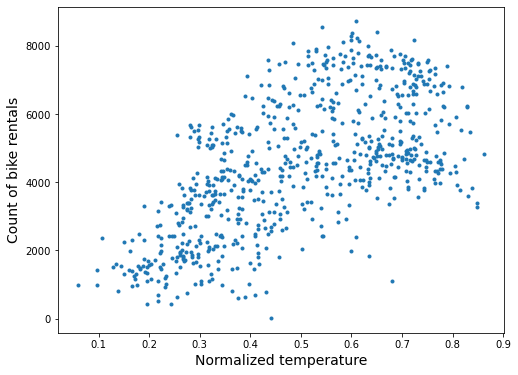

In [4]:
plt.figure(figsize = (8, 6))
plt.plot(bikes.temp, bikes.cnt, '.')
plt.xlabel('Normalized temperature', size=14)
plt.ylabel('Count of bike rentals', size=14)
plt.show()

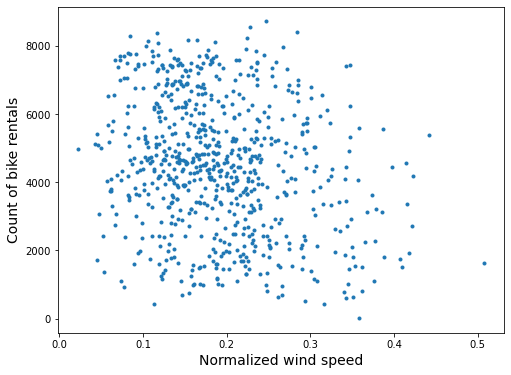

In [5]:
plt.figure(figsize = (8, 6))
plt.plot(bikes.windspeed, bikes.cnt, '.')
plt.xlabel('Normalized wind speed', size=14)
plt.ylabel('Count of bike rentals', size=14)
plt.show()

We begin with a simple Poisson regression:
$$
\begin{align*}
y_j &\sim \mathrm{Poisson}(\lambda_j) \\
\log \lambda_j &= \alpha + \beta_T T_j + \beta_w w_j \\
\alpha &\sim \mathrm{Normal}(0, 5) \\
\beta_T &\sim \mathrm{Normal}(0, 1) \\
\beta_w &\sim \mathrm{Normal}(0, 1) 
\end{align*}
$$

<ipython-input-6-1c9dcbd0eed7>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  bike_trace = pm.sample(1000, chains=4, cores=4, tune = 1000, target_accept = 0.8)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_wind, beta_temp, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.900349404007038, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069363256065092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804283468676031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9010371463849297, but should be close to 0.8. Try to increase the number of tuning steps.


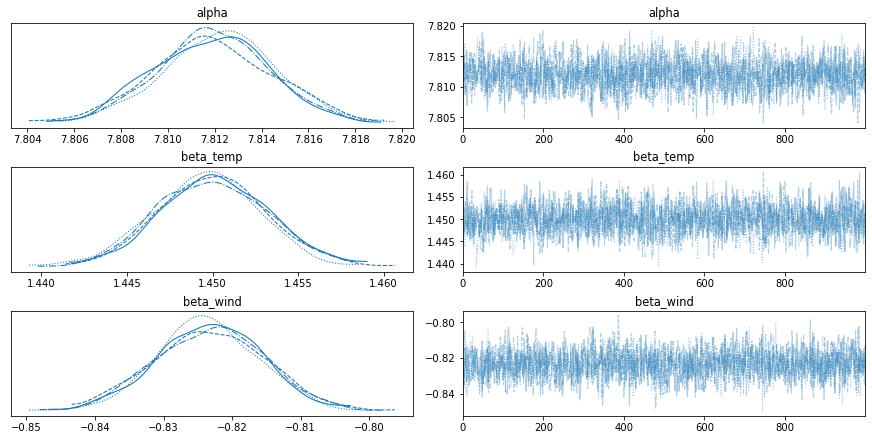

In [6]:
with pm.Model() as bike_model:
    alpha = pm.Normal('alpha', 0, 5)
    beta_temp = pm.Normal('beta_temp', 0, 2)
    beta_wind = pm.Normal('beta_wind', 0, 2)
        
    theta = pm.math.exp(alpha + beta_temp * bikes['temp'] + beta_wind * bikes['windspeed'])
    
    y_ = pm.Poisson('y', theta, observed = bikes['cnt'])
    bike_trace = pm.sample(1000, chains=4, cores=4, tune = 1000, target_accept = 0.8)
    bike_sum = az.summary(bike_trace)
    bike_ppc = pm.sample_posterior_predictive(bike_trace)
    az.plot_trace(bike_trace)

In [7]:
bike_sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.812,0.002,7.807,7.816,0.0,0.0,1392.0,1668.0,1.0
beta_temp,1.450,0.003,1.444,1.456,0.0,0.0,1580.0,1793.0,1.0
beta_wind,-0.823,0.008,-0.838,-0.809,0.0,0.0,1597.0,1794.0,1.0


To assess the fit of the model to the data, we'll draw a single posterior replication, and plot the true counts against the corresponding posterior predictions. We also check whether the difference between the observed and predicted counts appears to vary with time.

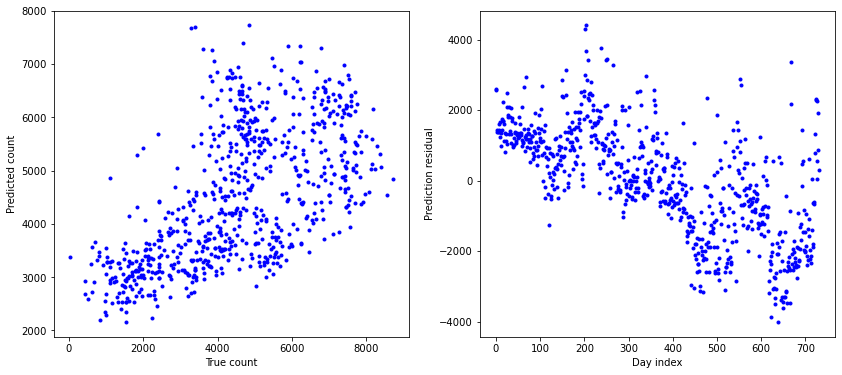

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(bikes['cnt'], bike_ppc['y'][0], '.', color = 'blue')
ax[0].set_xlabel("True count")
ax[0].set_ylabel("Predicted count")
ax[1].plot(bike_ppc['y'][0] - bikes['cnt'], '.', color = 'blue')
ax[1].set_xlabel("Day index")
ax[1].set_ylabel("Prediction residual")
plt.show()

The second plot shows clear time dependence, which motivates us to plot the count against day index.

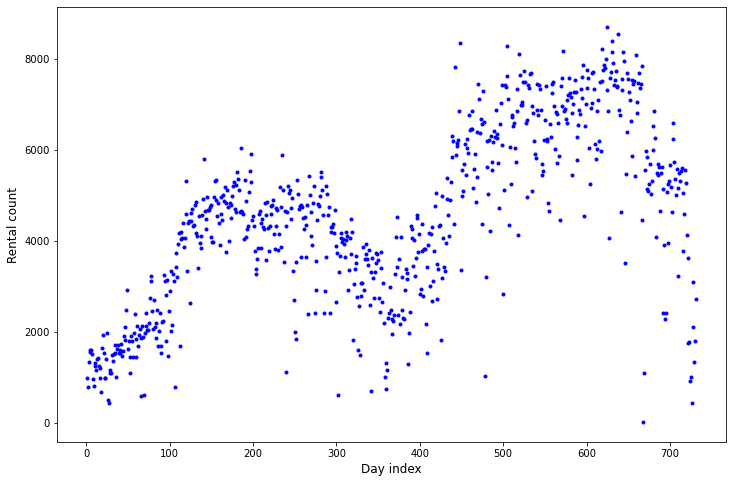

In [9]:
plt.figure(figsize=(12,8))
plt.plot(bikes['instant'], bikes['cnt'], 'b.')
plt.ylabel('Rental count', size = 12)
plt.xlabel('Day index', size=12)
plt.show()

We can see that there are clear time effects. Some of this is likely explained by our existing weather predictors. Some of the periods of low ridership are in the winter, so this variation will likely be captured by the temperature effect. But we can compare the summer of the second year to the summer of the first and see a clear increase in ridership. So, we should model this time variation as well.

We model this by pooling weekly data and including a weekly intercept, realized as an observation of a Gaussian process with exponentiated-quadratic covariance kernel. The distance matrix is a Toeplitz matrix, so we can exploit a routine from SciPy to quickly build it.

In [10]:
# Explicitly build the distance matrix for the covariance kernel
weekly_distance = sp.linalg.toeplitz(np.arange(105))
weekly_distance

array([[  0,   1,   2, ..., 102, 103, 104],
       [  1,   0,   1, ..., 101, 102, 103],
       [  2,   1,   0, ..., 100, 101, 102],
       ...,
       [102, 101, 100, ...,   0,   1,   2],
       [103, 102, 101, ...,   1,   0,   1],
       [104, 103, 102, ...,   2,   1,   0]])

Here is the new model:

$$
\begin{align*}
y_j &\sim \mathrm{Poisson}(\lambda_j) \\
\log \lambda_j &= \alpha_t + \beta_T T_j + \beta_w w_j \\
\pmb \alpha &\sim \mathrm{MVNormal}\left( 0, \mathbf{K} \right)\\
K_{ij} &= \eta^2 \exp \left( -\frac{1}{2} \frac{(i - j)^2}{\ell^2} \right) + 0.01 \delta_{ij} \\
\beta_T &\sim \mathrm{Normal}(0, 1) \\
\beta_w &\sim \mathrm{Normal}(0, 1) \\ 
\eta &\sim \mathrm{Exponential}(1) \\
\ell &\sim \mathrm{Exponential}(1) 
\end{align*}
$$

In [11]:
# Gaussian process model
with pm.Model() as bike_model_gp:
    beta_temp = pm.Normal('beta_temp', 0, 2)
    beta_wind = pm.Normal('beta_wind', 0, 2)
    eta = pm.Exponential('eta', 1)
    ls = pm.Exponential('ls', 1)
        
    # Gaussian process for time-varying intercepts. Include a small diagonal "ridge" component to aid numerical stability.
    cov_matrix = (eta ** 2) * pm.math.exp(-(weekly_distance ** 2) / (2 * ls ** 2)) + 0.01 * np.eye(105)
    alpha = pm.MvNormal('alpha', mu=tt.zeros(105), cov=cov_matrix, shape = 105)
    
    # Model equation
    theta = pm.math.exp(alpha[bikes['week']] + beta_temp * bikes['temp'] + beta_wind * bikes['windspeed'])
    
    y_ = pm.Poisson('y', theta, observed = bikes['cnt'])

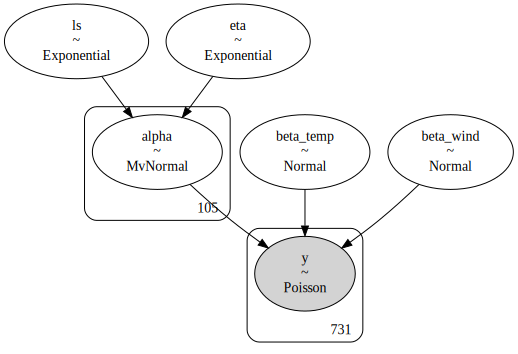

In [12]:
pm.model_to_graphviz(bike_model_gp)

In [13]:
with bike_model_gp:
    biketrace_gp = pm.sample(500, chains=4, cores=4, tune = 500, target_accept = 0.92, init = 'advi') # advi init really helps avoid sampling problems here
    bikesum_gp = az.summary(biketrace_gp)
    bike_ppc_gp = pm.sample_posterior_predictive(biketrace_gp)

<ipython-input-13-38f528814c57>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  biketrace_gp = pm.sample(500, chains=4, cores=4, tune = 500, target_accept = 0.92, init = 'advi') # advi init really helps avoid sampling problems here
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 26900
Interrupted at 26,899 [13%]: Average Loss = 6.7565e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, ls, eta, beta_wind, beta_temp]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 696 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
bikesum_gp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_temp,0.925,0.011,0.906,0.945,0.001,0.001,96.0,222.0,1.01
beta_wind,-0.602,0.009,-0.619,-0.587,0.000,0.000,1278.0,1619.0,1.00
alpha[0],7.054,0.011,7.032,7.075,0.000,0.000,780.0,1348.0,1.00
alpha[1],7.091,0.011,7.071,7.112,0.000,0.000,1125.0,1231.0,1.00
alpha[2],7.071,0.011,7.051,7.090,0.000,0.000,744.0,1045.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[102],8.248,0.007,8.236,8.260,0.000,0.000,280.0,784.0,1.00
alpha[103],7.330,0.010,7.311,7.348,0.000,0.000,637.0,1157.0,1.00
alpha[104],7.604,0.011,7.584,7.623,0.000,0.000,1038.0,1383.0,1.00
eta,4.660,0.996,3.040,6.608,0.317,0.231,10.0,38.0,1.32


Below we repeat the posterior predictive check from before. The agreement between true and predicted count is much better, and the residuals appear much less structured, suggesting that this model is doing much better.

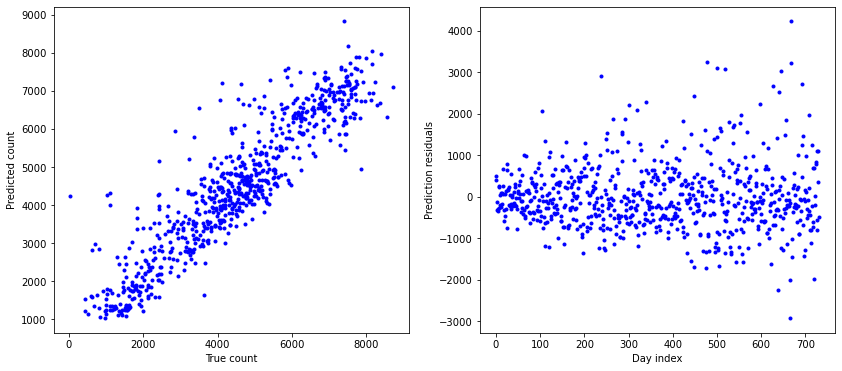

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(bikes['cnt'], bike_ppc_gp['y'][0], '.', color = 'blue')
ax[0].set_xlabel("True count")
ax[0].set_ylabel("Predicted count")
ax[1].plot(bike_ppc_gp['y'][0] - bikes['cnt'], '.', color = 'blue')
ax[1].set_xlabel("Day index")
ax[1].set_ylabel("Prediction residuals")
plt.show()

In addition to better fit-to-data, this model is able to describe the changes in ridership over time, after adjusting for weather effects, by tracking the estimated intercept against time.

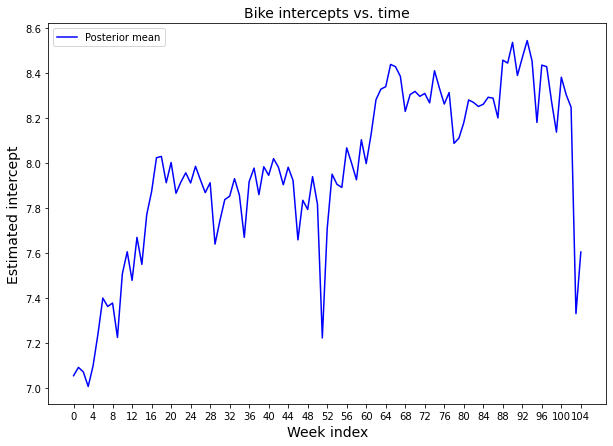

In [16]:
plt.figure(figsize=(10, 7))
plt.title("Bike intercepts vs. time",size=14)
plt.xlabel('Week index', size=14)
plt.xticks(np.arange(0, 105, 4))
plt.ylabel('Estimated intercept', size=14)
plt.plot(np.arange(0, 105), bikesum_gp.iloc[2:107]['mean'], color = 'blue', label = 'Posterior mean')
plt.legend()
plt.show()

This plot reveals the seasonality of the increases in bike share ridership. Gains in ridership generally occur in the spring, with ridership fairly flat during the summer and fall. Interestingly, no obvious seasonal effects appear in the late fall and early winter of the first year, suggesting that any seasonal variation there is adequately explained by the weather. The exception is a sharp drop around the very end of the year, likely corresponding to Christmas and New Year's Day.

## Rewriting using PyMC3's `gp` module

In [17]:
with pm.Model() as bike_model_gp:
    beta_temp = pm.Normal('beta_temp', 0, 2)
    beta_wind = pm.Normal('beta_wind', 0, 2)
    eta = pm.Exponential('eta', 1)
    ls = pm.Exponential('ls', 1)
        
    # Gaussian process for time-varying intercepts. Include a small diagonal "ridge" component to aid numerical stability.
    cov_func = (eta ** 2) * pm.gp.cov.ExpQuad(1, ls=ls) + 0.01 * pm.gp.cov.WhiteNoise(1)
    alpha_gp = pm.gp.Latent(cov_func=cov_func)
    f = alpha_gp.prior('f', X=bikes['week'][::7, None], reparameterize=False) # Poor sampling with reparameterization, so we set False here
    
    # Model equation
    theta = pm.math.exp(f[bikes['week']] + beta_temp * bikes['temp'] + beta_wind * bikes['windspeed'])
    
    y_ = pm.Poisson('y', theta, observed = bikes['cnt'])
    map_est = pm.find_MAP()
     # Like the original version, this does quite a bit better with advi for initialization
    trace = pm.sample(500, tune=500, chains=4, cores=4, init = 'advi', return_inferencedata=True)

<ipython-input-17-c3cb0ccaa529>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  f = alpha_gp.prior('f', X=bikes['week'][::7, None], reparameterize=False) # Poor sampling with reparameterization, so we set False here


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 26700
Interrupted at 26,699 [13%]: Average Loss = 6.8091e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, ls, eta, beta_wind, beta_temp]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 610 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Below, we use `plot_gp_dist` to replicate the plot from the previous section.

<ipython-input-18-4b6043a17214>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plot_gp_dist(ax, trace.posterior['f'][0,:,:], bikes.week[::7, None])


<AxesSubplot:>

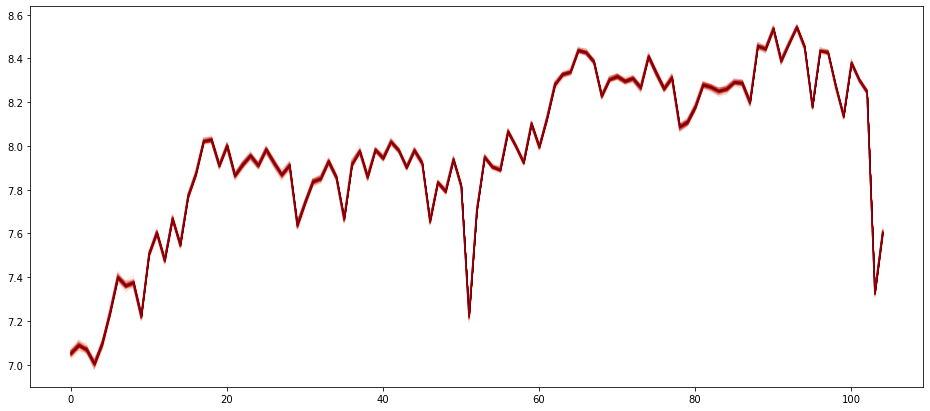

In [18]:
from pymc3.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,7))
ax = plt.gca()
plot_gp_dist(ax, trace.posterior['f'][0,:,:], bikes.week[::7, None])

In [19]:
toc = time.time()
print('Notebook ran in', round(toc - tic), 'seconds after imports.')
print('PyMC3 version', pm.__version__)
print('ArviZ version', az.__version__)

Notebook ran in 1676 seconds after imports.
PyMC3 version 3.11.2
ArviZ version 0.11.2
